<a href="https://colab.research.google.com/github/LucasArais/GuildaIA/blob/main/GuildaIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Guilda IA

#### Colocando em prática a multimodalidade, engenharia de Prompt e contagem de tokens

A multimodalidade em IA significa que um modelo pode processar e combinar diferentes tipos de dados ao mesmo tempo, como texto, imagem, áudio e vídeo. Isso permite que a IA tenha uma compreensão mais rica e contextualizada das informações.

Exemplos de Modelos Multimodais

- Gemini (Google) e GPT-4 Turbo (OpenAI) → Processam texto e imagens no mesmo modelo.

- DALL·E 3 → Gera imagens a partir de descrições textuais.

- Whisper (OpenAI) → Converte áudio em texto (reconhecimento de fala).

- Imagen & Stable Diffusion → Geram imagens realistas a partir de texto.


---

### Criando Imagens

O Gemini 2.0 Flash Experimental suporta geração nativa de imagens, permitindo que você crie e edite imagens diretamente por meio de prompts. Isso possibilita edições rápidas via chat e abre diversas possibilidades interessantes.

Você pode usar o modelo de geração de imagens gratuitamente no [Google AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-exp). Este notebook demonstra como implementar essa funcionalidade programaticamente utilizando o SDK Python, para que você possa desenvolver seus próprios aplicativos.

### Duas maneiras de enviar prompts

Você tem duas opções para enviar prompts:

1. Chat (mantém o histórico da conversa), ideal para edições rápidas

2. Chamadas isoladas, que oferecem mais controle sem manter o histórico da conversa

A seguir, veremos ambas as abordagens.

### Tipos de prompts para geração nativa de imagens
Para trabalhar com imagens, você pode utilizar dois tipos de prompts:

- Somente texto para criar uma imagem

    - Exemplo: "Crie uma imagem de..."

- Texto + imagem para edição de imagens

  - Exemplo: "Altere a cor da imagem..."

Vamos começar e aprender como fazer isso! Você também pode conferir mais detalhes na [documentação](https://ai.google.dev/gemini-api/docs/image-generation).



In [4]:
#Biblioteca do Google para interagir com modelos de inteligência artificial generativa, como o Gemini.
%pip install -U -q google-genai

In [5]:
# Importa a biblioteca Pillow para manipulação de imagens
from PIL import Image

# Importa BytesIO para trabalhar com imagens em memória sem salvar no disco
from io import BytesIO

# Importa display do IPython para exibir imagens diretamente no notebook
from IPython.display import display

Pegue uma chave de API gratuita [aqui](https://aistudio.google.com/apikey) e armazene-a como "Secret"

In [6]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [7]:
from google import genai
from google.genai import types

# Inicializa o cliente da API do Google Generative AI usando a chave de acesso
client = genai.Client(api_key=GOOGLE_API_KEY)

O nome do modelo para geração de imagens:

In [8]:
MODEL_ID = "gemini-2.0-flash-exp-image-generation"

## 1. Use o chat para edição rápida de imagens

O chat mantém o histórico da conversa. Use um chat se quiser que o modelo lembre das interações e edições anteriores. Isso permite que o modelo utilize esse contexto ao gerar novas imagens, facilitando edições rápidas e iterativas.

**Obs**: Para usar a geração nativa de imagens, é necessário definir `response_modalities` como `'Text'` e `'Image'`. Não é permitido usar apenas imagem.

In [9]:
# Cria uma instância de chat usando o modelo especificado
chat = client.chats.create(
    model=MODEL_ID,  # ID do modelo de IA que será utilizado na conversa

    # Configuração do modelo para definir o formato da resposta
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']  # Permite respostas em texto e imagem
    )
)

In [10]:
response = chat.send_message("Crie a imagem de um jogador de futebol - o messi com a camisa do barcelona")

# Se você já tem uma imagem e deseja carregá-la, use isto:

# response = chat.send_message([
#     "Mude a cor do cabelo para azul",
#     Image.open('foto.png')])

Defina uma função auxiliar para exibir a saída (a resposta pode conter texto e imagem):

In [11]:
def display_response(response, filename_to_save=None):
    for part in response.candidates[0].content.parts:
        if part.text is not None:
            print(part.text)
        elif part.inline_data is not None:
            # imprimir o tipo MIME da imagem
            image = Image.open(BytesIO(part.inline_data.data))
            if filename_to_save:  # se um nome de arquivo opcional for fornecido, salvamos a imagem
                image.save(filename_to_save)
            image.thumbnail((300, 300))  # reduzir o tamanho apenas para exibição
            display(image)

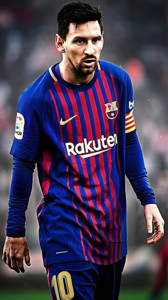

In [12]:
display_response(response, "girl.png")  # também salvamos a imagem aqui

Agora você pode editar com mais prompts:

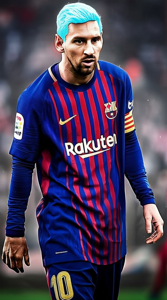

In [13]:
response = chat.send_message("mude a cor do cabelo para azul")

display_response(response)

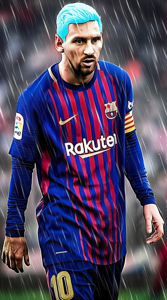

In [14]:
response = chat.send_message("adicione uma chuva leve")

display_response(response)



---

### Detecção de objetos e bounding box com Gemini

(1203, 790)


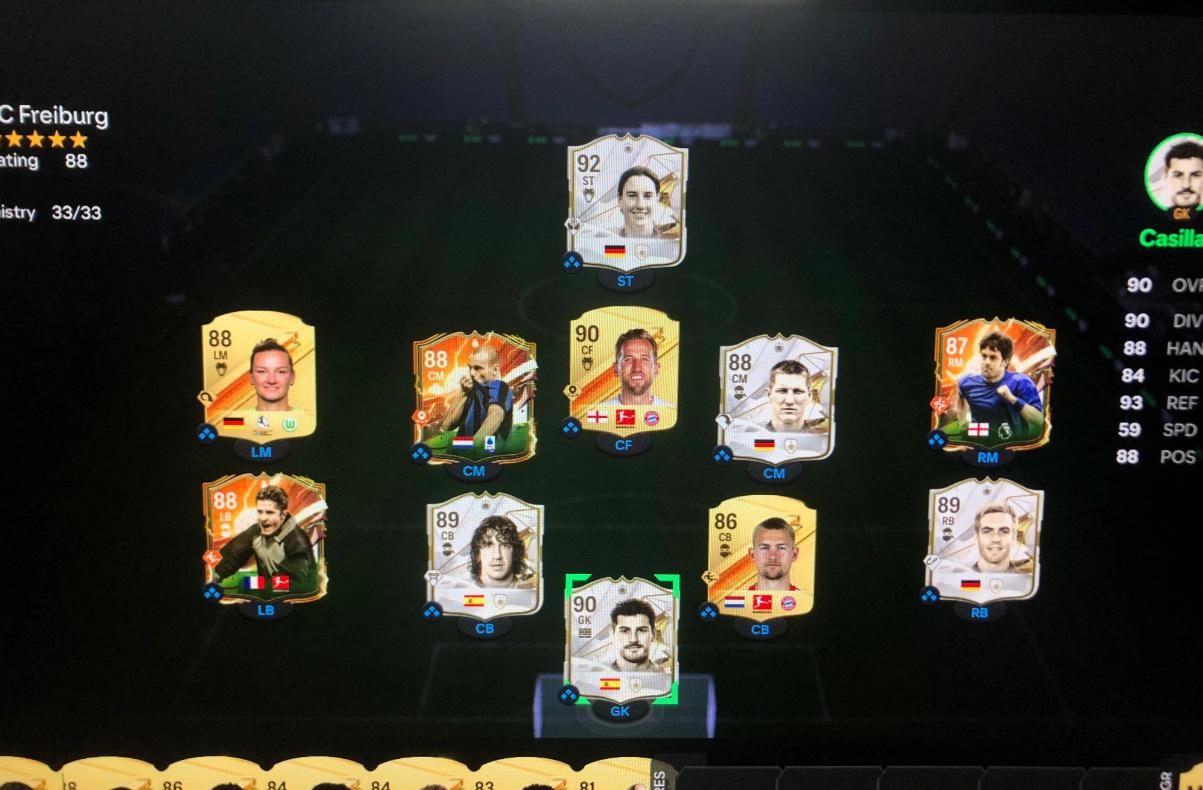

In [17]:
import requests
from io import BytesIO
from PIL import Image

# URL da imagem hospedada no GitHub
url = 'https://github.com/LucasArais/gemini/raw/f9f5905978d83df3d7632c824d50542ed5ff295e/data/fifa.png'

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()
    image = Image.open(BytesIO(response.content))
    print(image.size)
    display(image)
except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
except PIL.UnidentifiedImageError as e:
    print(f"Error opening image: {e}")

In [18]:
%pip install -U -q google-genai

In [19]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [20]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

## Detectar caixas delimitadoras  

Defina o esquema da caixa delimitadora.  

**Importante**: O Gemini retorna as coordenadas da caixa delimitadora neste formato:  
- `[y_min, x_min, y_max, x_max]`  
- e normalizadas para `[0,1000]`

In [21]:
# Definir o esquema da caixa delimitadora.
from pydantic import BaseModel

class BoundingBox(BaseModel):
  box_2d: list[int]
  label: str

Defina o prompt.

In [26]:
prompt = """Detecte as caixas delimitadoras 2D de todos os jogadores que foram campeões da Copa do mundo de Futebol por seus paises.
O rótulo correspondente deve ser o país que ele representou na Copa do Mundo e o ano que ele ganhou a copa em portugues-br"""

**Execute** o modelo. `gemini-2.5-pro-exp-03-25` é muito bom, `gemini-2.0-flash` também funciona bem e é mais rápido.

In [27]:
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25", # "gemini-2.0-flash"
    contents=[prompt, image],
    config={
        'response_mime_type': 'application/json',
        'response_schema': list[BoundingBox],
    },
)

# Analisar a resposta JSON
bounding_boxes = response.parsed
bounding_boxes

[BoundingBox(box_2d=[421, 594, 585, 698], label='Alemanha 2014'),
 BoundingBox(box_2d=[404, 773, 573, 879], label='Inglaterra 1966'),
 BoundingBox(box_2d=[651, 353, 784, 454], label='Espanha 2010'),
 BoundingBox(box_2d=[719, 465, 892, 567], label='Espanha 2010'),
 BoundingBox(box_2d=[616, 768, 765, 869], label='Alemanha 2014'),
 BoundingBox(box_2d=[614, 167, 768, 272], label='Fran\tca 1998'),
 BoundingBox(box_2d=[172, 950, 280, 1000], label='Espanha 2010')]

Desenhe as caixas delimitadoras:

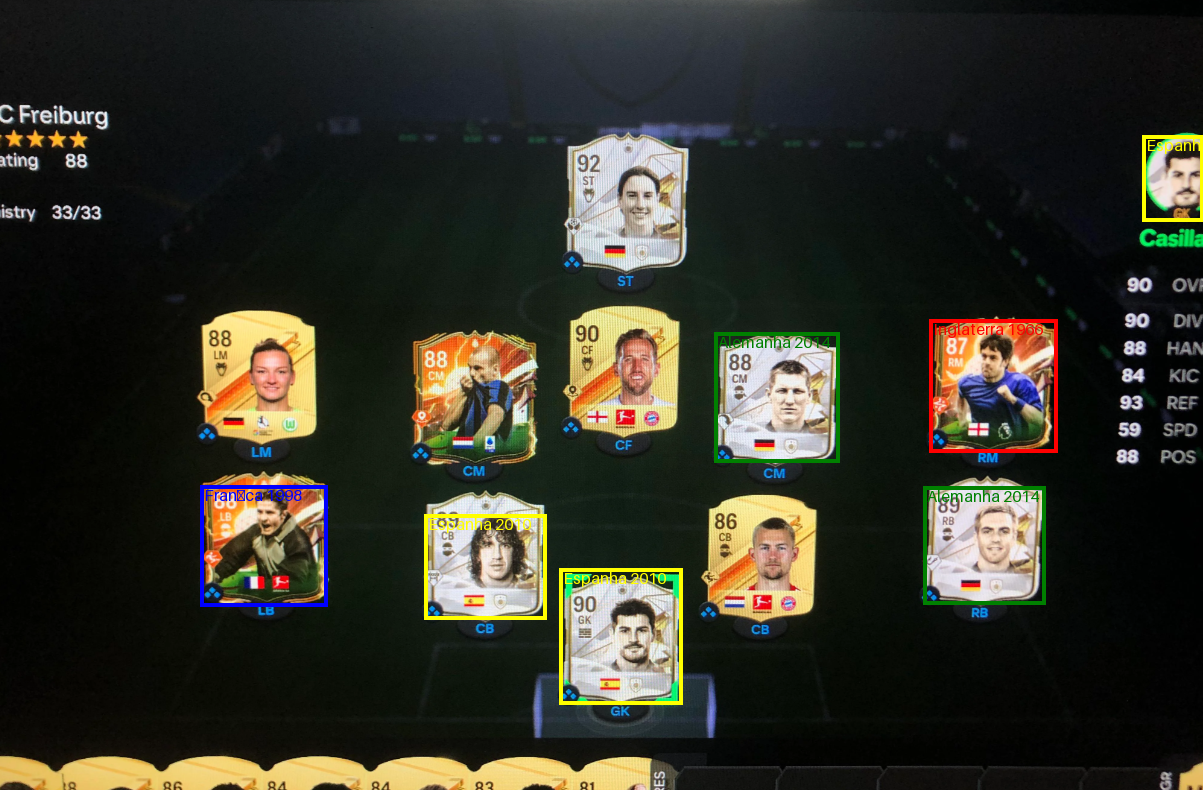

In [28]:
from PIL import ImageDraw, ImageFont

line_width = 4
font = ImageFont.load_default(size=16)

labels = list(set(box.label for box in bounding_boxes))

def draw_bounding_boxes(image, bounding_boxes):
    img = image.copy()
    width, height = img.size

    draw = ImageDraw.Draw(img)

    colors = ['blue','red','green','yellow','orange','pink','purple']

    for box in bounding_boxes:
        y_min, x_min, y_max, x_max = box.box_2d
        label = box.label

        # Converte coordenadas normalizadas para coordenadas absolutas
        y_min = int(y_min/1000 * height)
        x_min = int(x_min/1000 * width)
        y_max = int(y_max/1000 * height)
        x_max = int(x_max/1000 * width)

        color = colors[labels.index(label) % len(colors)]
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)

        draw.text((x_min+line_width, y_min), label, fill=color, font=font)

    display(img)

draw_bounding_boxes(image, bounding_boxes)

In [29]:
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25",
    contents=[prompt],
)

print(f"Total de tokens usados: {response.usage_metadata.total_token_count}")




Total de tokens usados: 1623
